# Working with Unlabeled Data – Cluster Analysis
Find the best number of clusters with __k_means__ and __agglomerative clustering__

## Overview

1. Load the data file
    - check the shape and plot the content  
1. Observe the pair plot and comment the shapes in view of clustering 
    1. if necessary, transform the data
1. Use the elbow method to find the optimal number of clusters, to do this test `KMeans` with varying number of clusters, from 2 to 10: for each value of `k` 
    - fit the data
    - compute the __inertia__ and the __silhouette score__  
    - store them for plot
1. Plot inertia and silhouette score versus `k`
1. Choose the optimal number of clusters looking at the plots
1. Cluster the data using the optimal number, plot the cluster assignment 
    - in the plot choose the features that seem to be most promising
        

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import ParameterGrid
from typing import List
import warnings
warnings.filterwarnings("ignore")

random_state = 42 # This variable will be used in all the procedure calls allowing a random_state parameter
               # in this way the running can be perfectly reproduced
               # just change this value for a different experiment

## 1. Load the data file

`wholesale.csv` from the `data` folder

Check the shape and plot the content 

In [2]:
df = pd.read_csv('../data/wholesale.csv')
df.shape

(440, 8)

In [3]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## 2. Observe the data distributions

<Axes: >

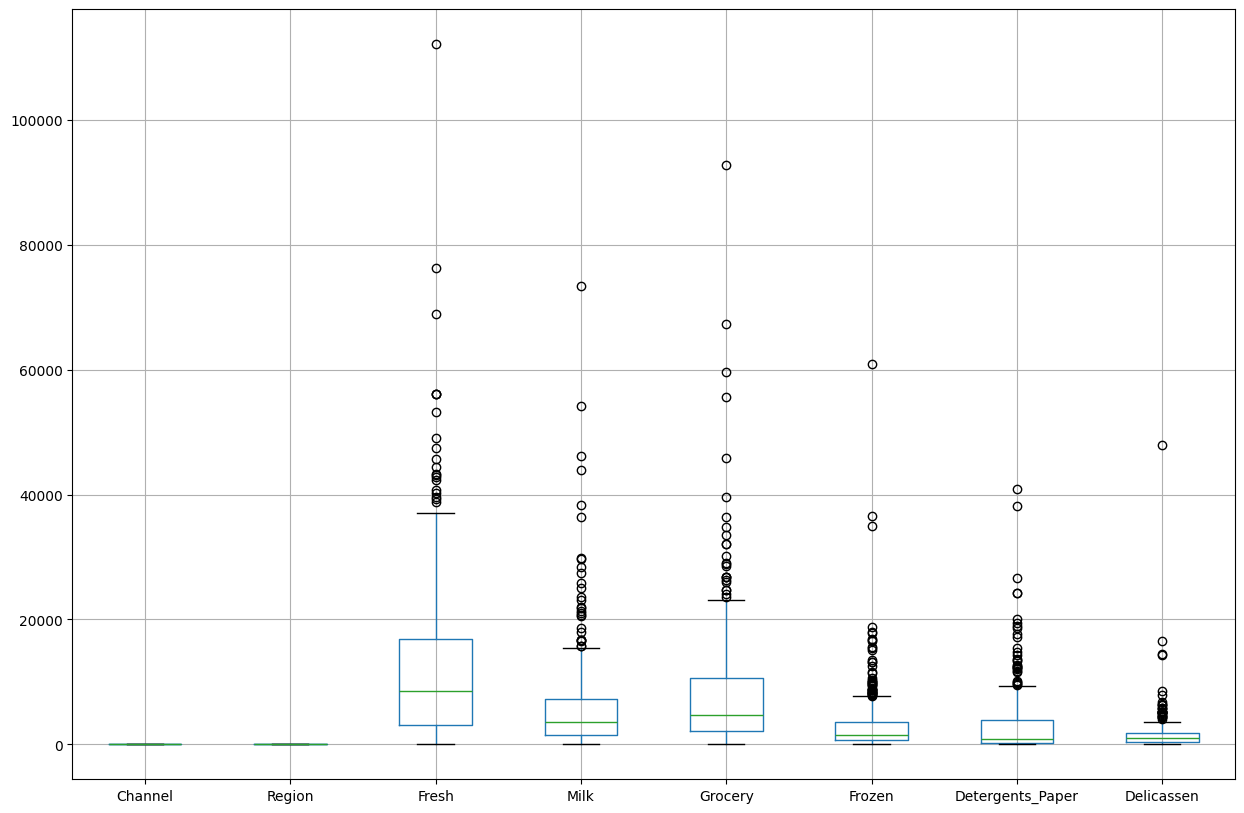

In [4]:
df.boxplot(figsize=(15,10))

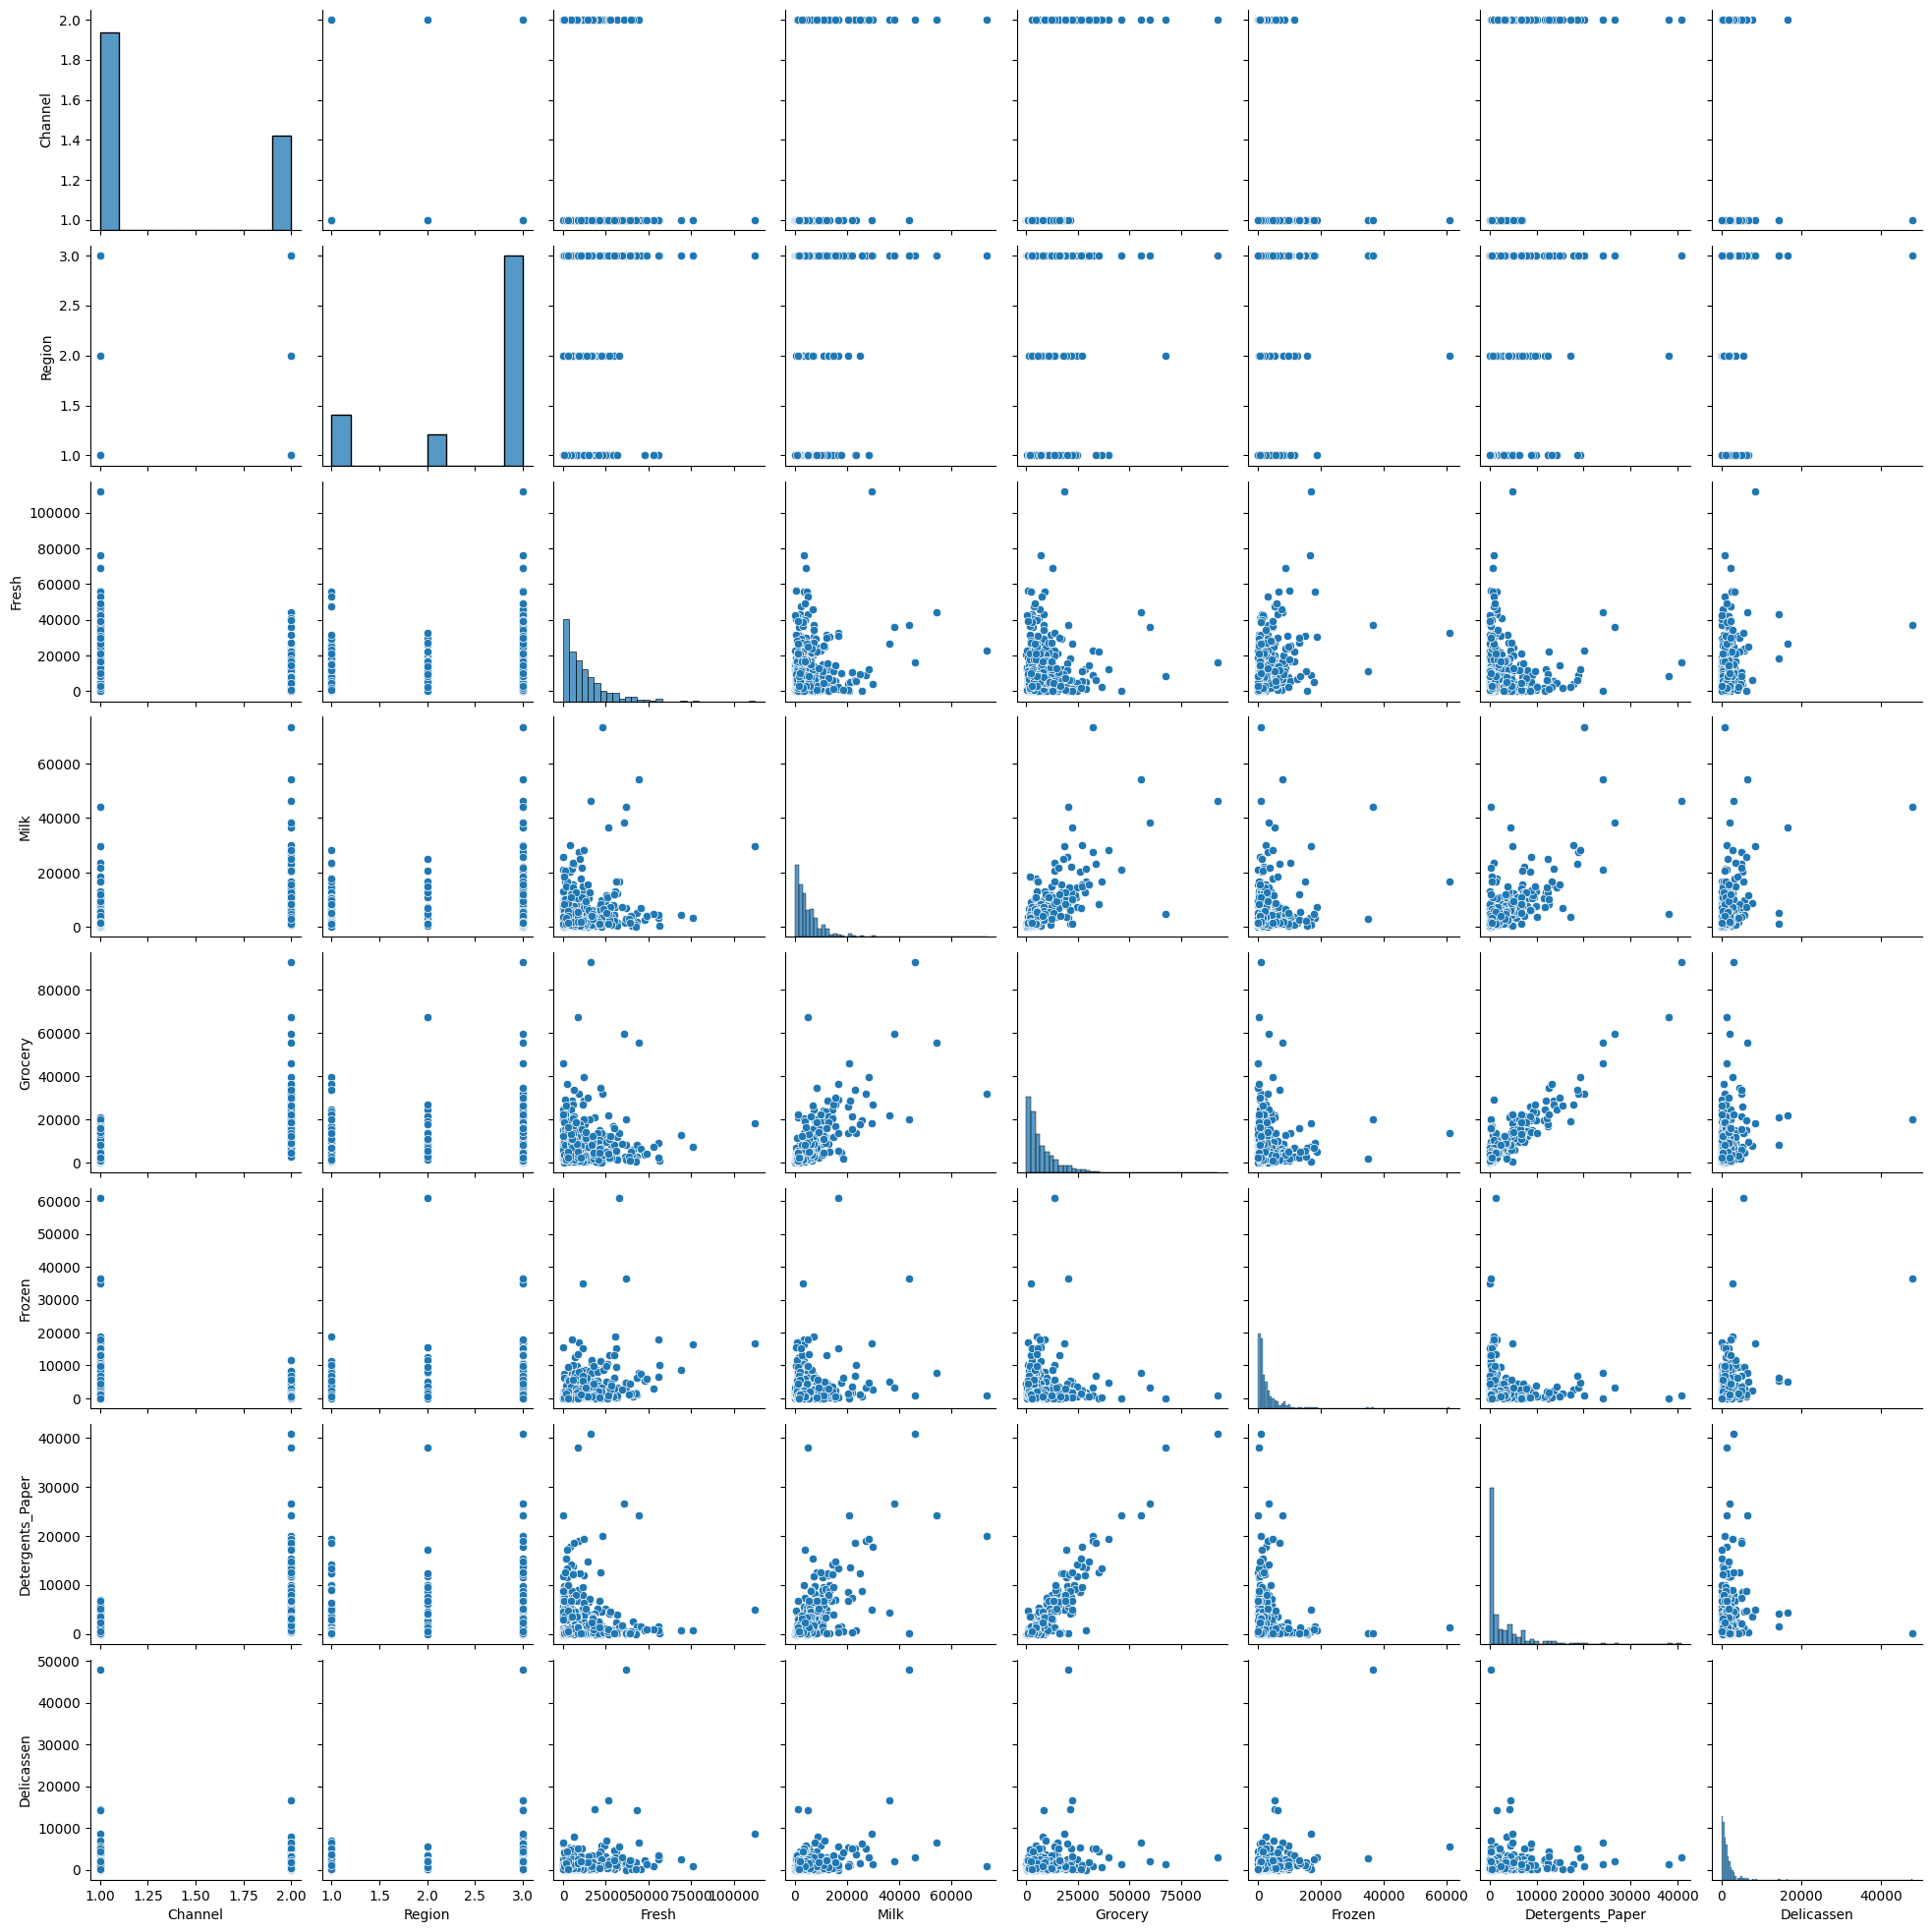

In [5]:
sns.pairplot(df)
plt.show()

We observe that the distributions of values are definitely *skewed*: in the columns from `Fresh` to `Delicassen` the values are highly concentrated on the right, but there are always outliers, frequently in a very large range.

Clustering is more effective in absence of outliers and with all the variables distributed in similar ranges, for this reason, we will execute two transformations:
1. transform all the variables from the column `Fresh` to the column `Delicassen` with [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html)
1. remap all the variables in the range `0:1` with `MinMaxScaler`

In [6]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

fresh_index = df.columns.get_loc('Fresh')
cols_to_powertransform = df.columns[fresh_index:]

pt = PowerTransformer()
scaler = MinMaxScaler()

df[cols_to_powertransform] = pt.fit_transform(df[cols_to_powertransform])
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,1.0,1.0,0.501828,0.667606,0.625238,0.208640,0.649941,0.412016
1,1.0,1.0,0.414266,0.670028,0.655690,0.458800,0.674852,0.445663
2,1.0,1.0,0.400077,0.653586,0.627297,0.499856,0.682752,0.654292
3,0.0,1.0,0.509368,0.369264,0.553550,0.636716,0.461095,0.446485
4,1.0,1.0,0.604755,0.580657,0.618985,0.566470,0.601884,0.590255


Show the result of the transformation

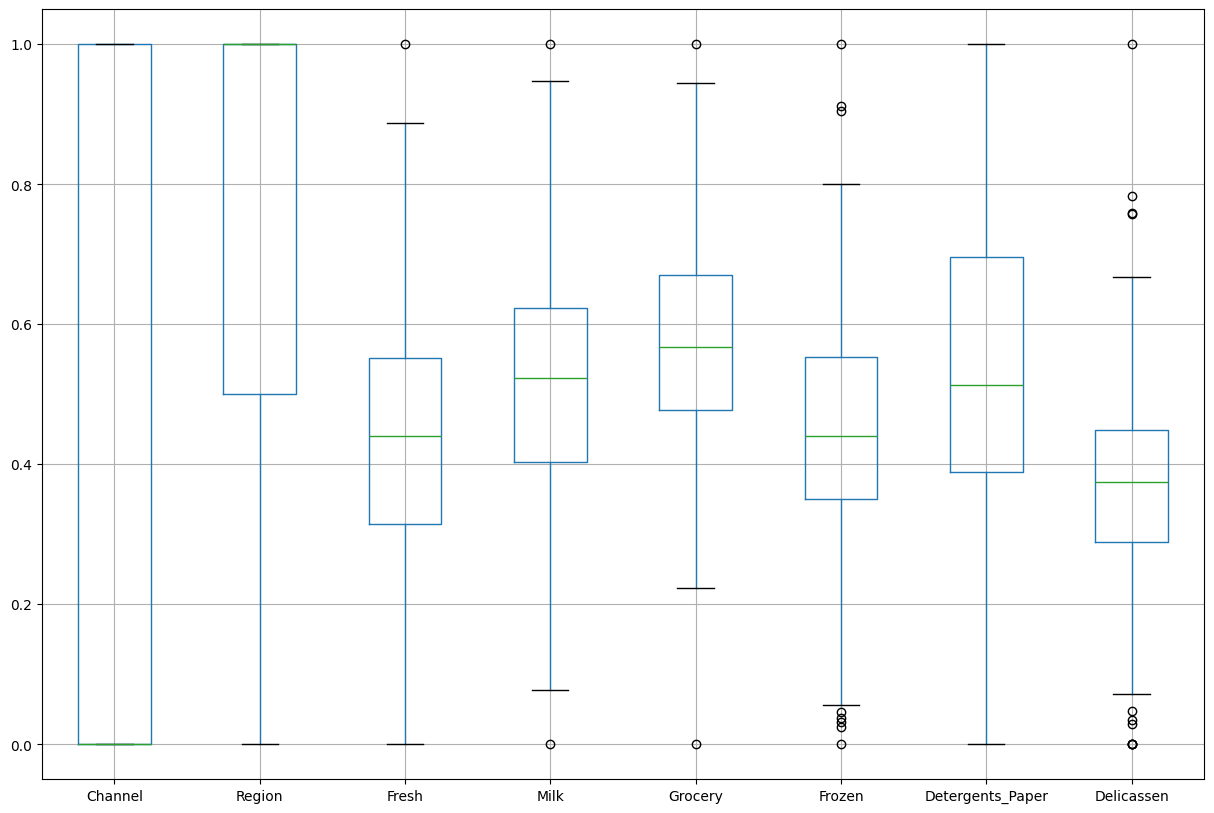

In [7]:
df.boxplot(figsize=(15,10))
plt.show()

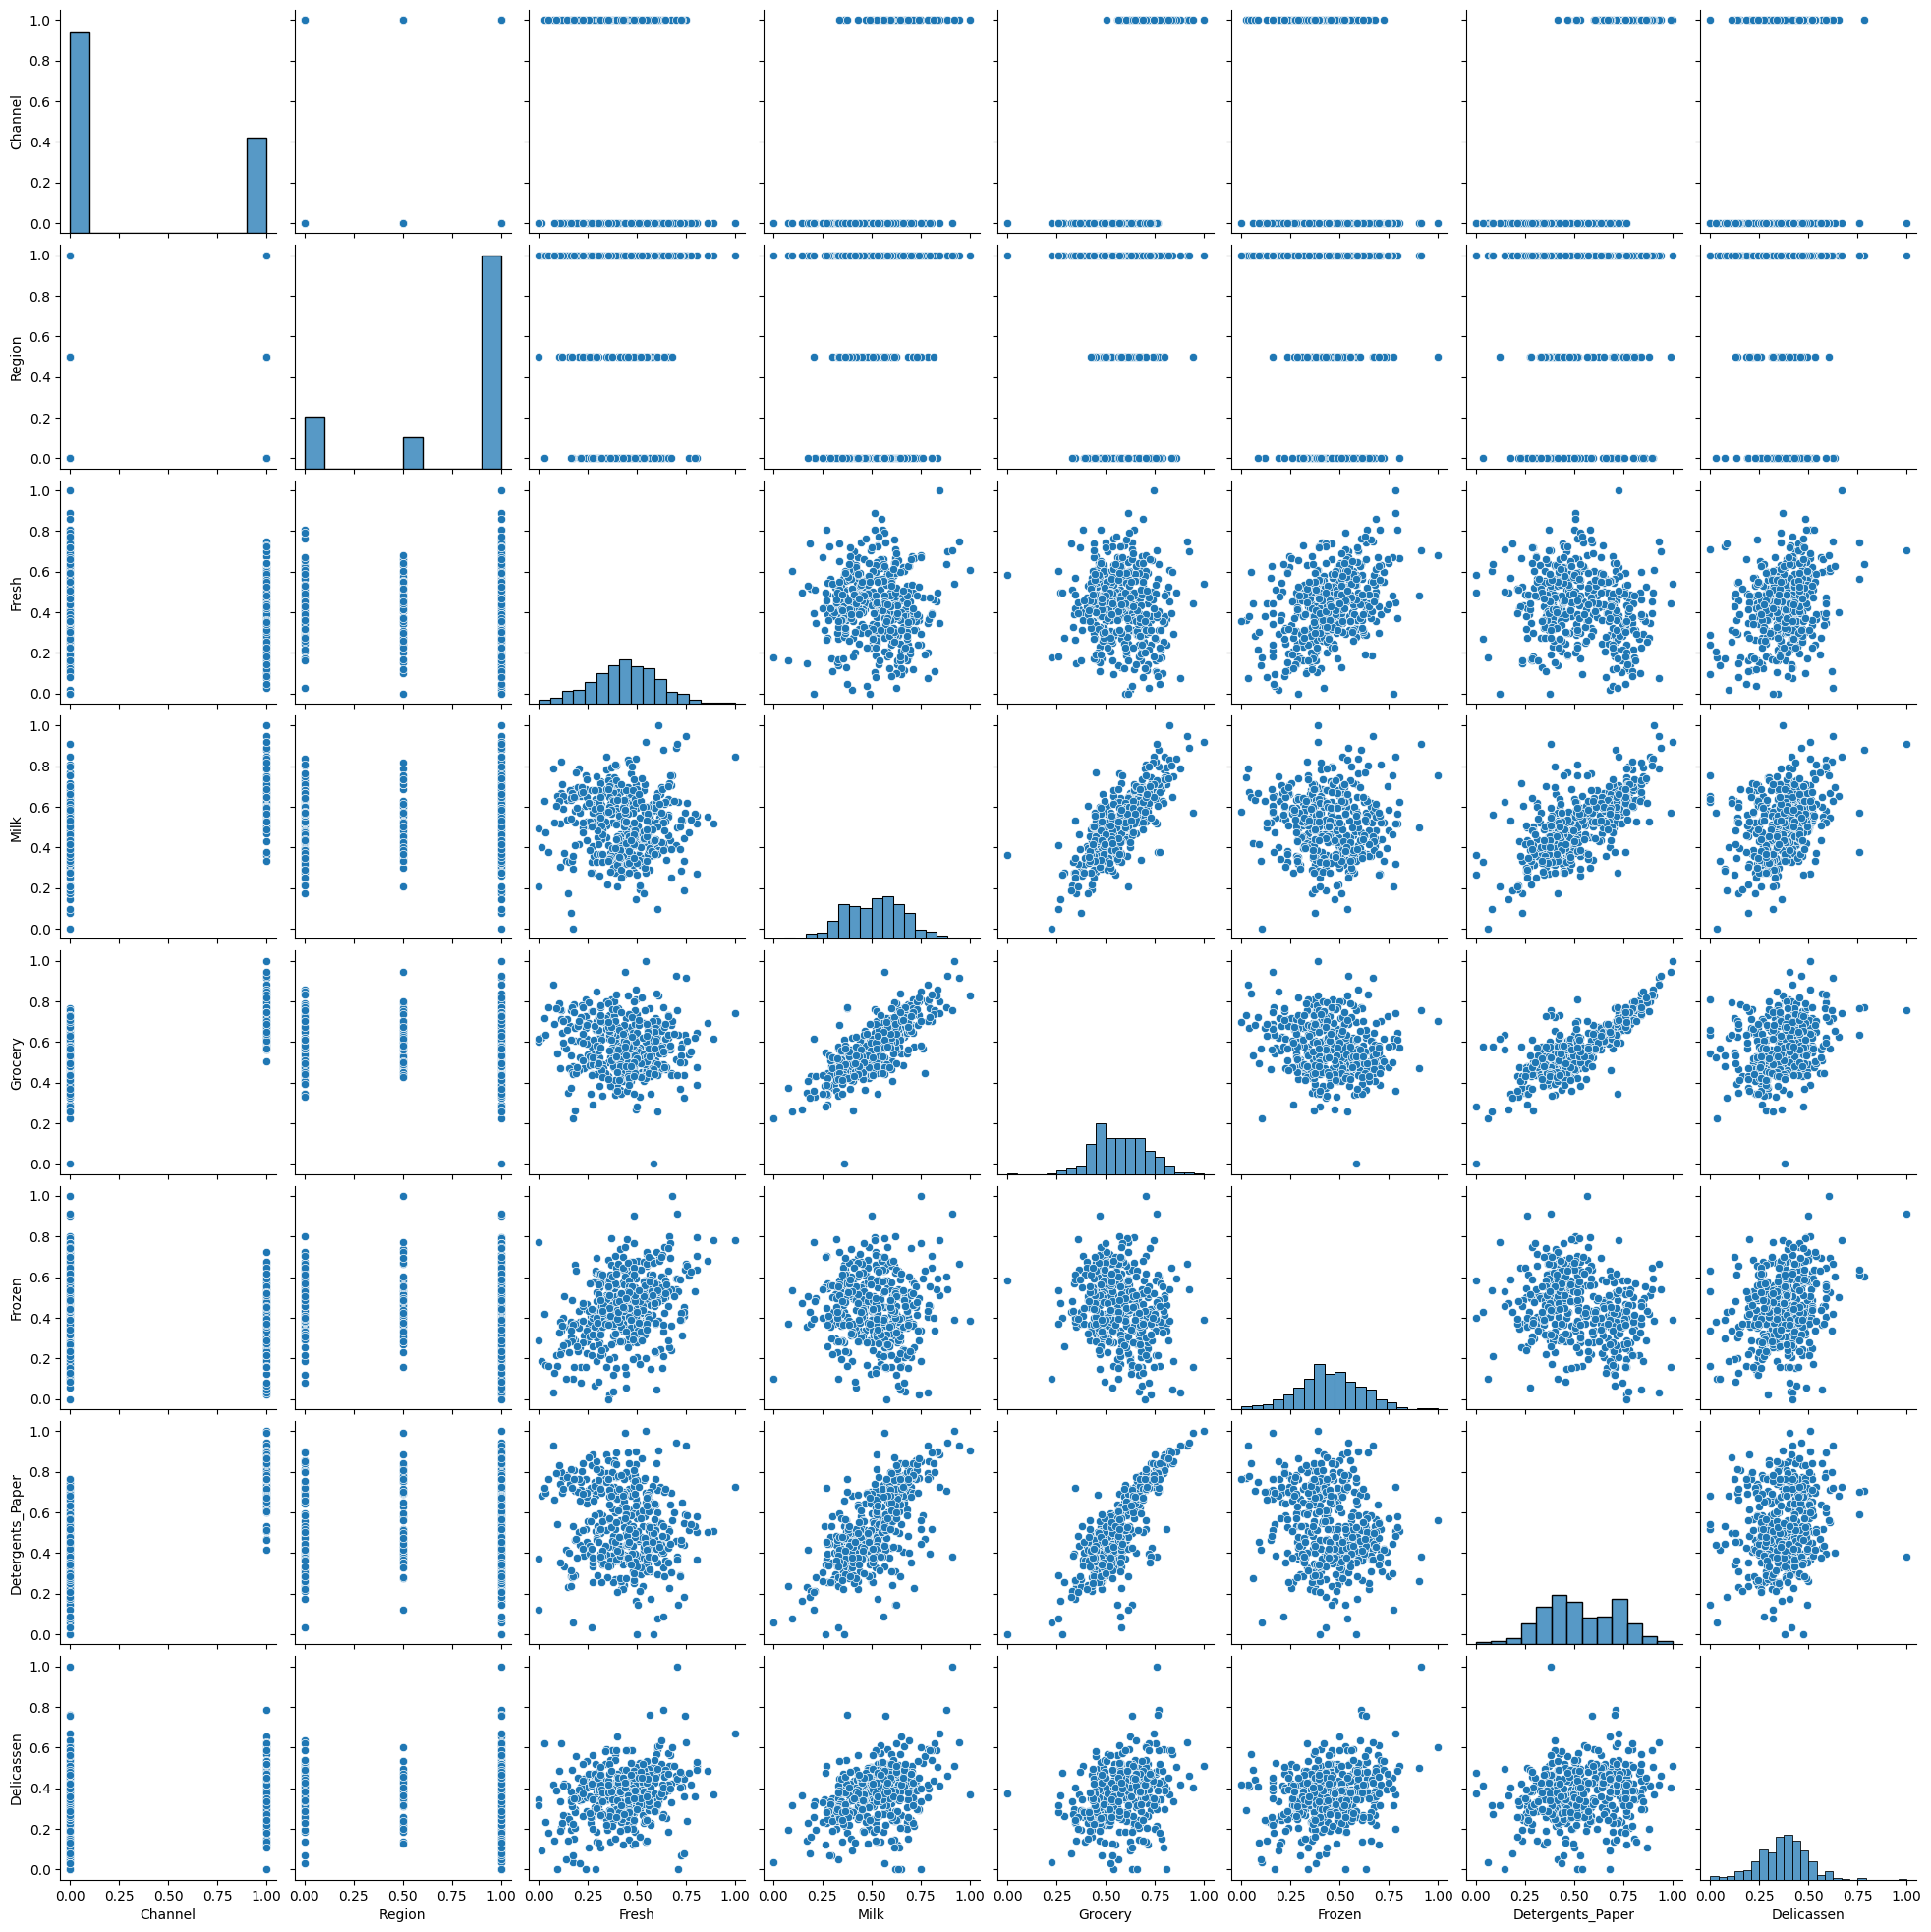

In [8]:
sns.pairplot(df)
plt.show()

Now the effect of outliers is reduced, and we compute the clustering

## 3. Use the elbow method to find the optimal number of clusters
Test `KMeans` with varying number of clusters, from 2 to 10

Prepare the results list that will contain pairs of `inertia` and `silhouette_score` for each value of `k`, then, __for each value__ of `k` 
- initialize an estimator for `KMeans`
- fit the data and predict the cluster assignment for each individual with `fit` and `predict`
- the __inertia__ is provided in the attribute `inertia_` of the fitted model
- compute the __silhouette score__  using the function `silhouette_score` from `sklearn.metrics` using as arguments the data and the fitted labels, we will fill the variable `silhouette_scores`
- store the two values above in the list created at the beginning

In [31]:
pg = list(ParameterGrid([{'n_clusters': list(range(2,11))}]))
kmeans_metric: List[dict] = []

for arg in range(len(pg)):
    kmeans = KMeans(**pg[arg], random_state=random_state)
    y_km = kmeans.fit_predict(df)
    silhouette_avg = silhouette_score(df, y_km)
    kmeans_metric.append({'n_clusters': pg[arg]['n_clusters'], 'silhouette_avg': silhouette_avg, 'inertia': kmeans.inertia_})

## 4. Plot __inertia__ and __silhouette score__ versus `k`

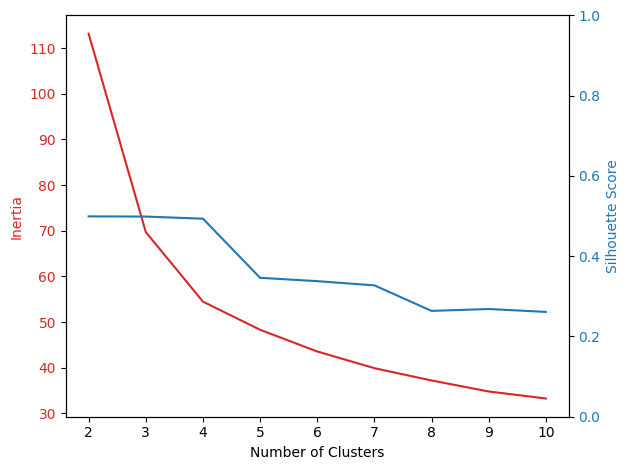

In [13]:
metrics_df = pd.DataFrame(kmeans_metric)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(metrics_df['n_clusters'], metrics_df['inertia'], color=color)
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(metrics_df['n_clusters'], metrics_df['silhouette_avg'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0,1)

fig.tight_layout()
plt.show()


## 5. Cluster with the optimal number
The two *elbow* points of inertia would suggest as cluster number 3 or 4, slightly more pronounced in 3. Silhouette has a maximum on 4, but the increase with respect to 3 is very small.

We will choose k=4

In [32]:
four_cluster_kmeans = KMeans(n_clusters=4, random_state=random_state)
y_km = four_cluster_kmeans.fit_predict(df)

print(f"Number of clusters = 4 - Distortion = {four_cluster_kmeans.inertia_:.4} - Silhouette Score = {silhouette_score(df, y_km):.2}")

Number of clusters = 4 - Distortion = 54.49 - Silhouette Score = 0.49


In [33]:
df['cluster'] = y_km

Show the distribution of samples in the clusters with a pie chart

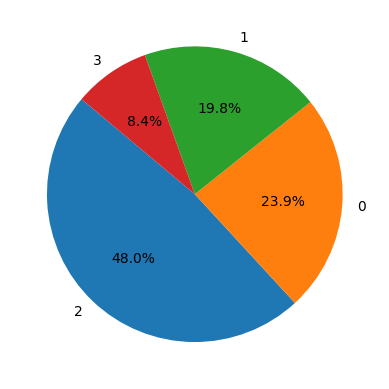

In [34]:
plt.pie(df['cluster'].value_counts(), labels=df['cluster'].value_counts().index, autopct='%1.1f%%', startangle=140)
plt.show()

### Comments
The __silhouette score__ ranges from `-1` (worst) to `1` (best); as a rule of thumb, a value greater than `0.5` should be considered acceptable.

## Additional tasks
1. Repeat the experiments without the data transformations and comment the result
1. Repeat the final fittings with the numbers of clusters immediately before and after the chosen values and comment the results